In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 경고 문구 off
import warnings
warnings.filterwarnings('ignore')

# 1. 상황인식


1. 4가지 데이터 

 - entry_data: '모두 스터디카페'의 시간별 입장 기록 데이터
 - sales_data: '모두 스터디카페'의 시간별 음식/음료 판매 데이터
 - item_data: '모두 스터디카페'에서 판매하고 있는 음식/음료 종류와 가격
 - item_entry_data: '모두 스터디카페'에서 판매하고 있는 입장권 종류와 가격


2. 핵심적 분석

 - 월별 매출액 추세
 - 가장 인기있는 음식/음료
 - 가장 많이 팔린 입장권 종류


3. 전략 수립 및 실행

# 2. 데이터 분석

## (1) 데이터 불러오기

In [2]:
sales_data = pd.read_csv('StudyCafe/sales_data.csv')
entry_data = pd.read_csv('StudyCafe/entry_data.csv')
item_data = pd.read_csv('StudyCafe/item_data.csv')
item_entry_data = pd.read_csv('StudyCafe/item_entry_data.csv')

In [3]:
sales_data.head()

,결제일시,판매위치,상품명,결제방식,비고,판매수량,결제금액,고객
0,2022-04-01 19:41,선불기1,치킨카라아케 6pc,신용카드,결제완료,1,"4,500",customer275507
1,2022-04-01 19:41,선불기1,짜장라면(계란추가),신용카드,결제완료,1,"5,500",customer275507
2,2022-04-01 19:41,선불기1,라면,신용카드,결제완료,1,"4,000",customer275507
3,2022-04-01 19:41,선불기1,비엔나소세지(토핑),신용카드,결제완료,1,"1,000",customer275507
4,2022-04-01 19:41,선불기1,라면(계란/치즈추가),신용카드,결제완료,1,"5,000",customer275507


In [4]:
entry_data.head()

,요금제명,입실,퇴실,이용,위치,금액,구분,고객
0,시간요금제(1시간),2022-04-01 23:39,2022-04-02 0:39,오전 1:00:00,선불기2,3000,퇴실,customer263717
1,시간요금제(1시간),2022-04-01 23:39,2022-04-02 0:39,오전 1:00:00,선불기2,3000,퇴실,customer263717
2,무제한 입장권,2022-04-01 20:55,2022-04-01 21:41,오전 12:46:00,선불기2,7400,퇴실,customer247263
3,무제한 입장권,2022-04-01 20:55,2022-04-01 21:41,오전 12:46:00,선불기2,7400,퇴실,customer247263
4,한국대생 무제한 입장권,2022-04-01 19:54,2022-04-01 22:28,오전 2:33:00,선불기2,7400,퇴실,customer388928


In [5]:
item_data.head()

,구분,분류,상품명,판매금액
0,1,게임&TV,이어폰(커널형),"3,000원"
1,2,디저트,초코머핀,"3,500원"
2,3,디저트,쿠키(초코칩),"1,500원"
3,4,디저트,쿠키(마카다미아),"1,500원"
4,5,디저트,미니마카롱(3개),"2,000원"


In [6]:
item_entry_data.head()

,순위,분류,상품명,판매금액
0,1,한국대생,한국대생 요금제,"2,000원"
1,2,심야-조조,심야-조조 요금제,"5,000원"
2,3,일반인,일반요금제,"2,500원"
3,4,한국대생,한국대생 요금제,"2,500원"
4,5,일반인,일반요금제,"2,000원"


## (2) 데이터 분석하기

### - 1) 월별 매출액 추세

In [7]:
# 활용할 데이터(sales_data)를 sales_df로 정의하기
sales_df = sales_data

# sales_df의 date열을 만들고, sales_date의 결제일시 중 앞에서 7번째 값까지 할당
sales_df.insert(0, 'date', sales_data['결제일시'].str[:7])

# salse_data의 결제금액에 포함된 쉼표(,) 지우고 숫자형태로 바꿔서 sales_df에 컬럼 생성
sales_data['결제금액'] = sales_data['결제금액'].str.replace(',', '')
sales_df.insert(5, 'payment', sales_data['결제금액'].astype(int))

del sales_df['판매위치']
del sales_df['결제방식']
del sales_df['결제금액']

sales_df = sales_df[sales_df['판매수량']==1]
sales_df.head()

,date,결제일시,상품명,payment,비고,판매수량,고객
0,2022-04,2022-04-01 19:41,치킨카라아케 6pc,4500,결제완료,1,customer275507
1,2022-04,2022-04-01 19:41,짜장라면(계란추가),5500,결제완료,1,customer275507
2,2022-04,2022-04-01 19:41,라면,4000,결제완료,1,customer275507
3,2022-04,2022-04-01 19:41,비엔나소세지(토핑),1000,결제완료,1,customer275507
4,2022-04,2022-04-01 19:41,라면(계란/치즈추가),5000,결제완료,1,customer275507


In [8]:
# sales_df의 payment를 기준으로 집계하기
payment_data = sales_df['payment'].groupby(sales_df['date']).sum()
payment_data = pd.DataFrame(payment_data)
payment_data.reset_index(drop=False, inplace=True)
payment_data.rename(columns={'payment':'월별매출액'}, inplace=True)
payment_data

,date,월별매출액
0,2021-02,40000
1,2021-03,2139000
2,2021-04,3170100
3,2021-05,2595500
4,2021-06,3674000
5,2021-07,1275500
6,2021-08,1243000
7,2021-09,1216500
8,2021-10,2233500
9,2021-11,2776000


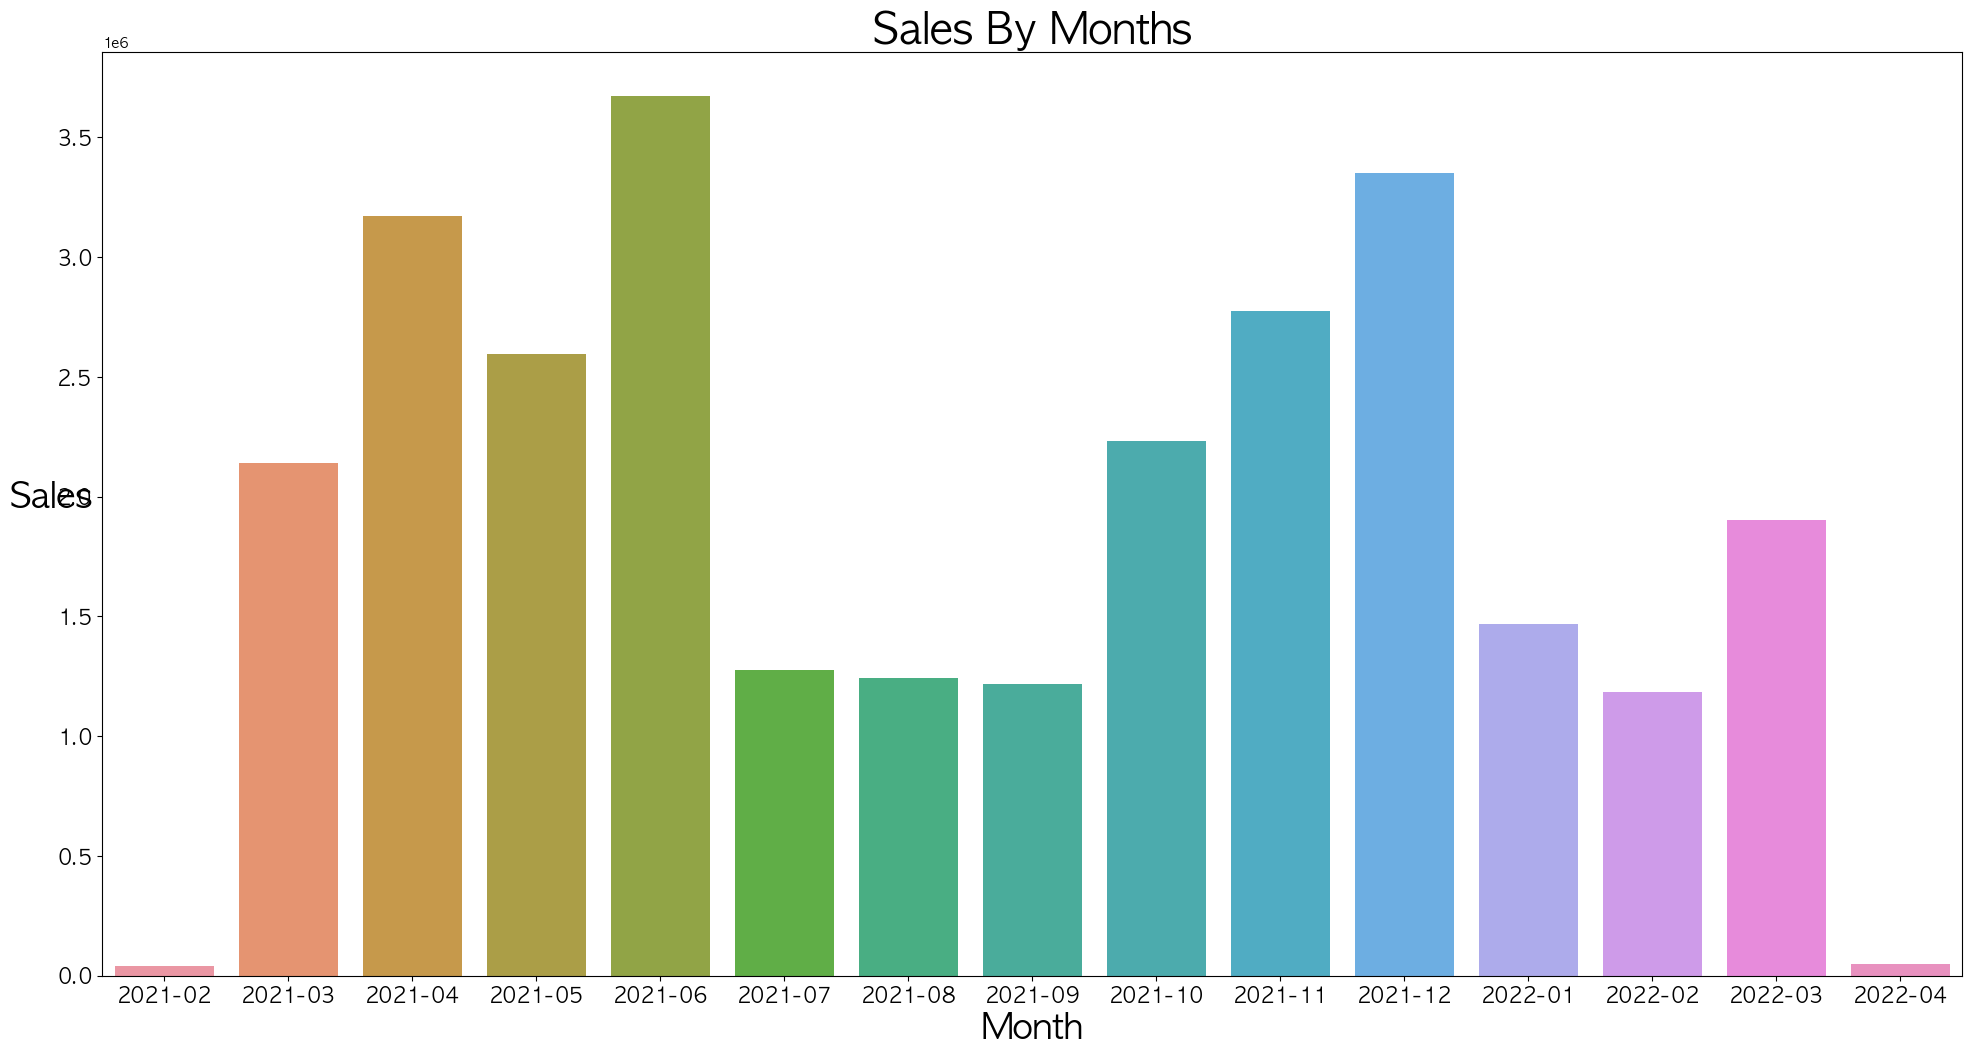

In [9]:
# 집계 결과 시각화
plt.figure(figsize = (24, 12))
sns.barplot(data=payment_data, x='date', y='월별매출액')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Month', fontsize = 25)
plt.ylabel('Sales', fontsize = 25, rotation=0)
plt.title('Sales By Months', fontsize = 30)
plt.show()

### - 2) 가장 인기있는 음식/음료

#### (1) 상품별 판매수량 Top 10

In [10]:
# sales_df의 상품명을 기준으로 집계하기
items_count = sales_df.groupby(sales_df['상품명']).sum()

# item_count의 값을 내림차순으로 정렬하고 상위 10개 도출하기
items_count = items_count.sort_values('판매수량',ascending=False)
items_count_top10 = items_count[:10]
items_count_top10.reset_index(drop=False, inplace=True)
items_count_top10.rename(columns={'payment':'매출액'}, inplace=True)
items_count_top10

,상품명,매출액,판매수량
0,김치볶음밥,6004400,1204
1,라면,2941500,749
2,짜장라면,2038500,455
3,치즈불고기볶음밥,2292600,420
4,계란추가,157000,314
5,낙지볶음밥,1710700,312
6,새우볶음밥,1539800,309
7,아메리카노(ICE),1058100,284
8,치즈감자튀김,1354200,246
9,감자튀김,1083800,242


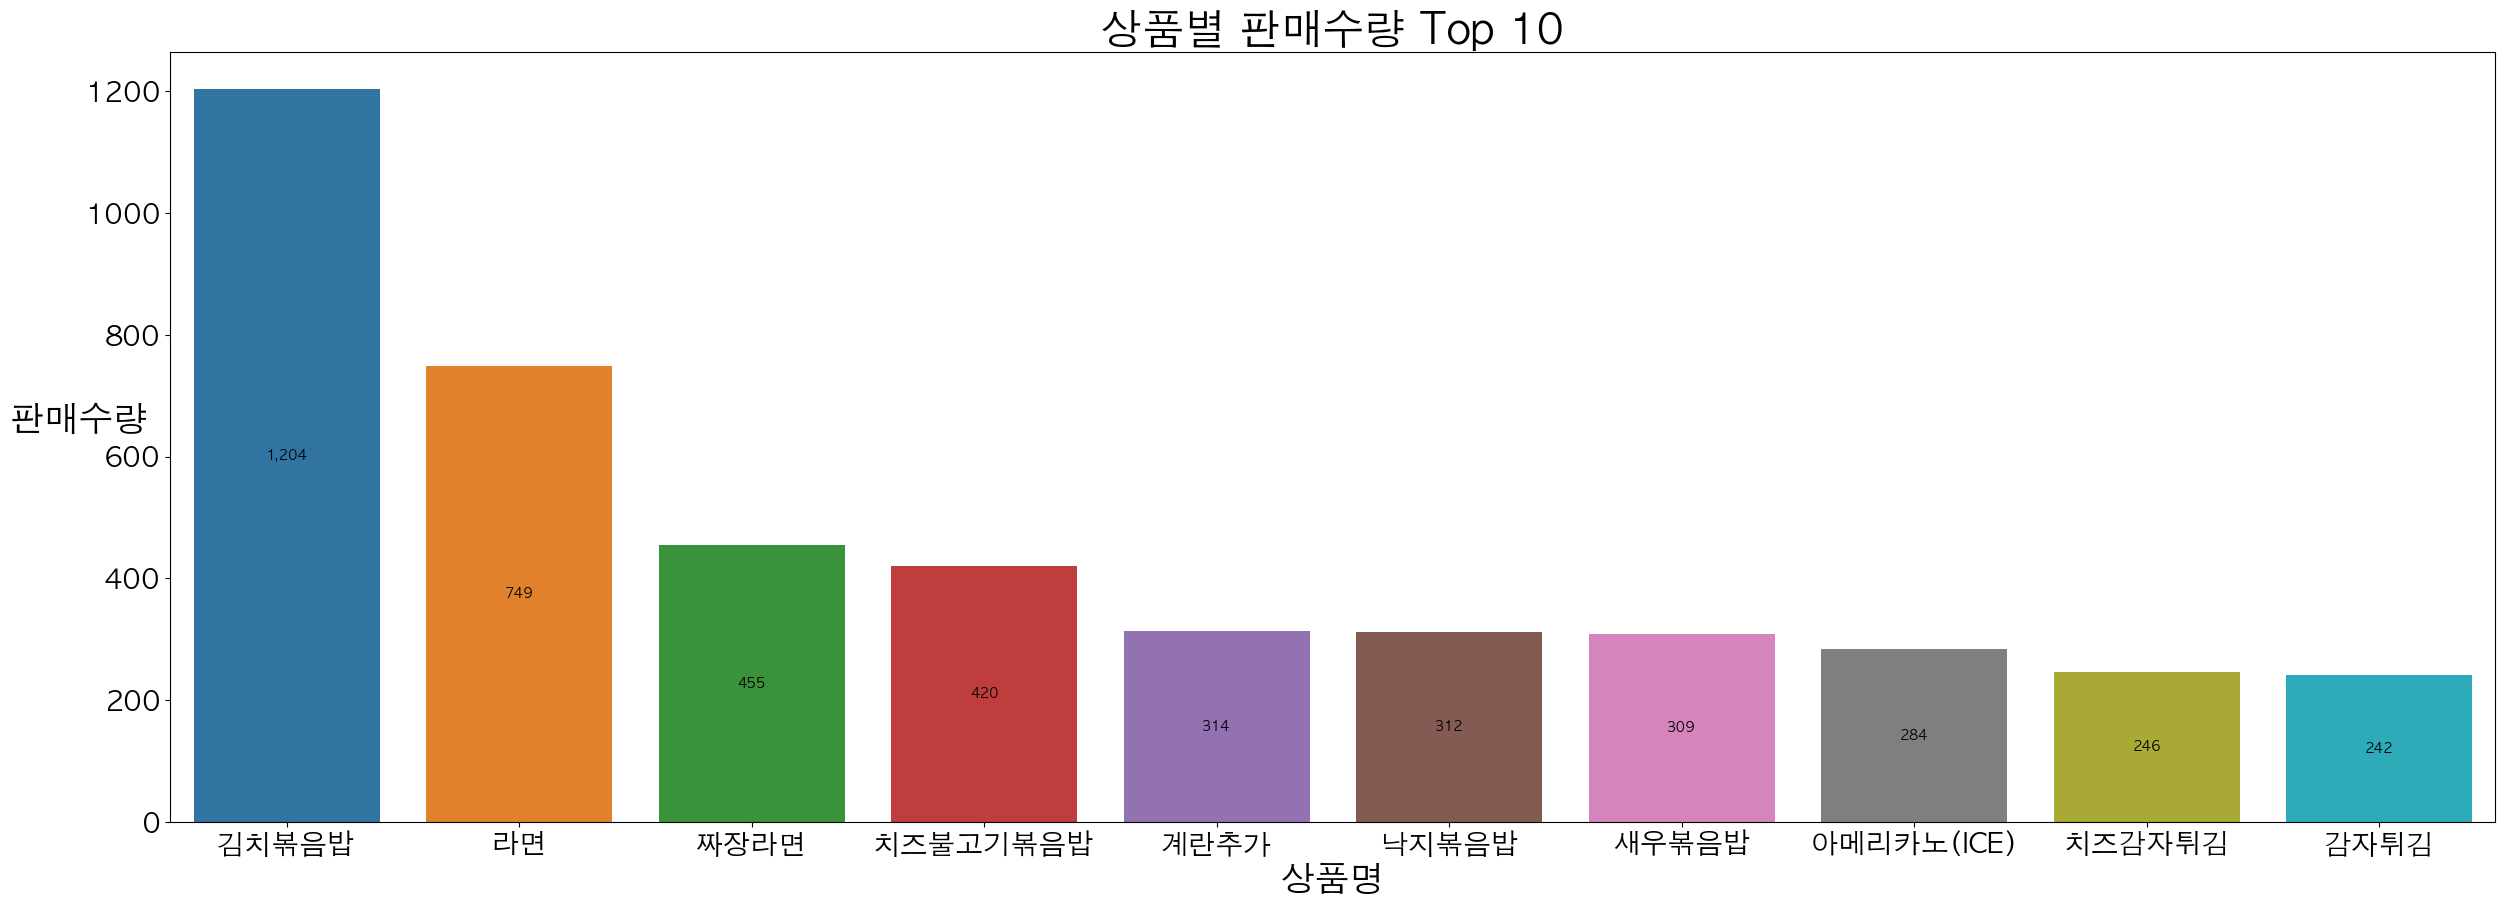

In [11]:
# 집계 결과 시각화
plt.figure(figsize = (30, 10))
ax = sns.barplot(data=items_count_top10, x='상품명', y='판매수량')
containers = ax.containers[0]
ax.bar_label(containers, labels=[f'{x:,.0f}' for x in containers.datavalues], label_type='center')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('상품명', fontsize = 25)
plt.ylabel('판매수량', fontsize = 25, rotation=0)
plt.title('상품별 판매수량 Top 10', fontsize = 30)
plt.show()

#### (2) 상품별 매출액 Top 10

In [12]:
# sales_df의 payment열을 상품명을 기준으로 집계하기
items_payment = sales_df['payment'].groupby(sales_df['상품명']).sum()

# item_payment의 값을 내림차순으로 정렬하고 상위 10개 도출하기
items_payment = items_payment.sort_values(ascending=False)
items_payment_top10 = items_payment[:10]
items_payment_top10 = pd.DataFrame(items_payment_top10)
items_payment_top10.reset_index(drop=False, inplace=True)
items_payment_top10.rename(columns={'payment':'매출액'}, inplace=True)
items_payment_top10

,상품명,매출액
0,김치볶음밥,6004400
1,라면,2941500
2,치즈불고기볶음밥,2292600
3,짜장라면,2038500
4,낙지볶음밥,1710700
5,새우볶음밥,1539800
6,치즈감자튀김,1354200
7,감자튀김,1083800
8,아메리카노(ICE),1058100
9,불닭볶음면,693000


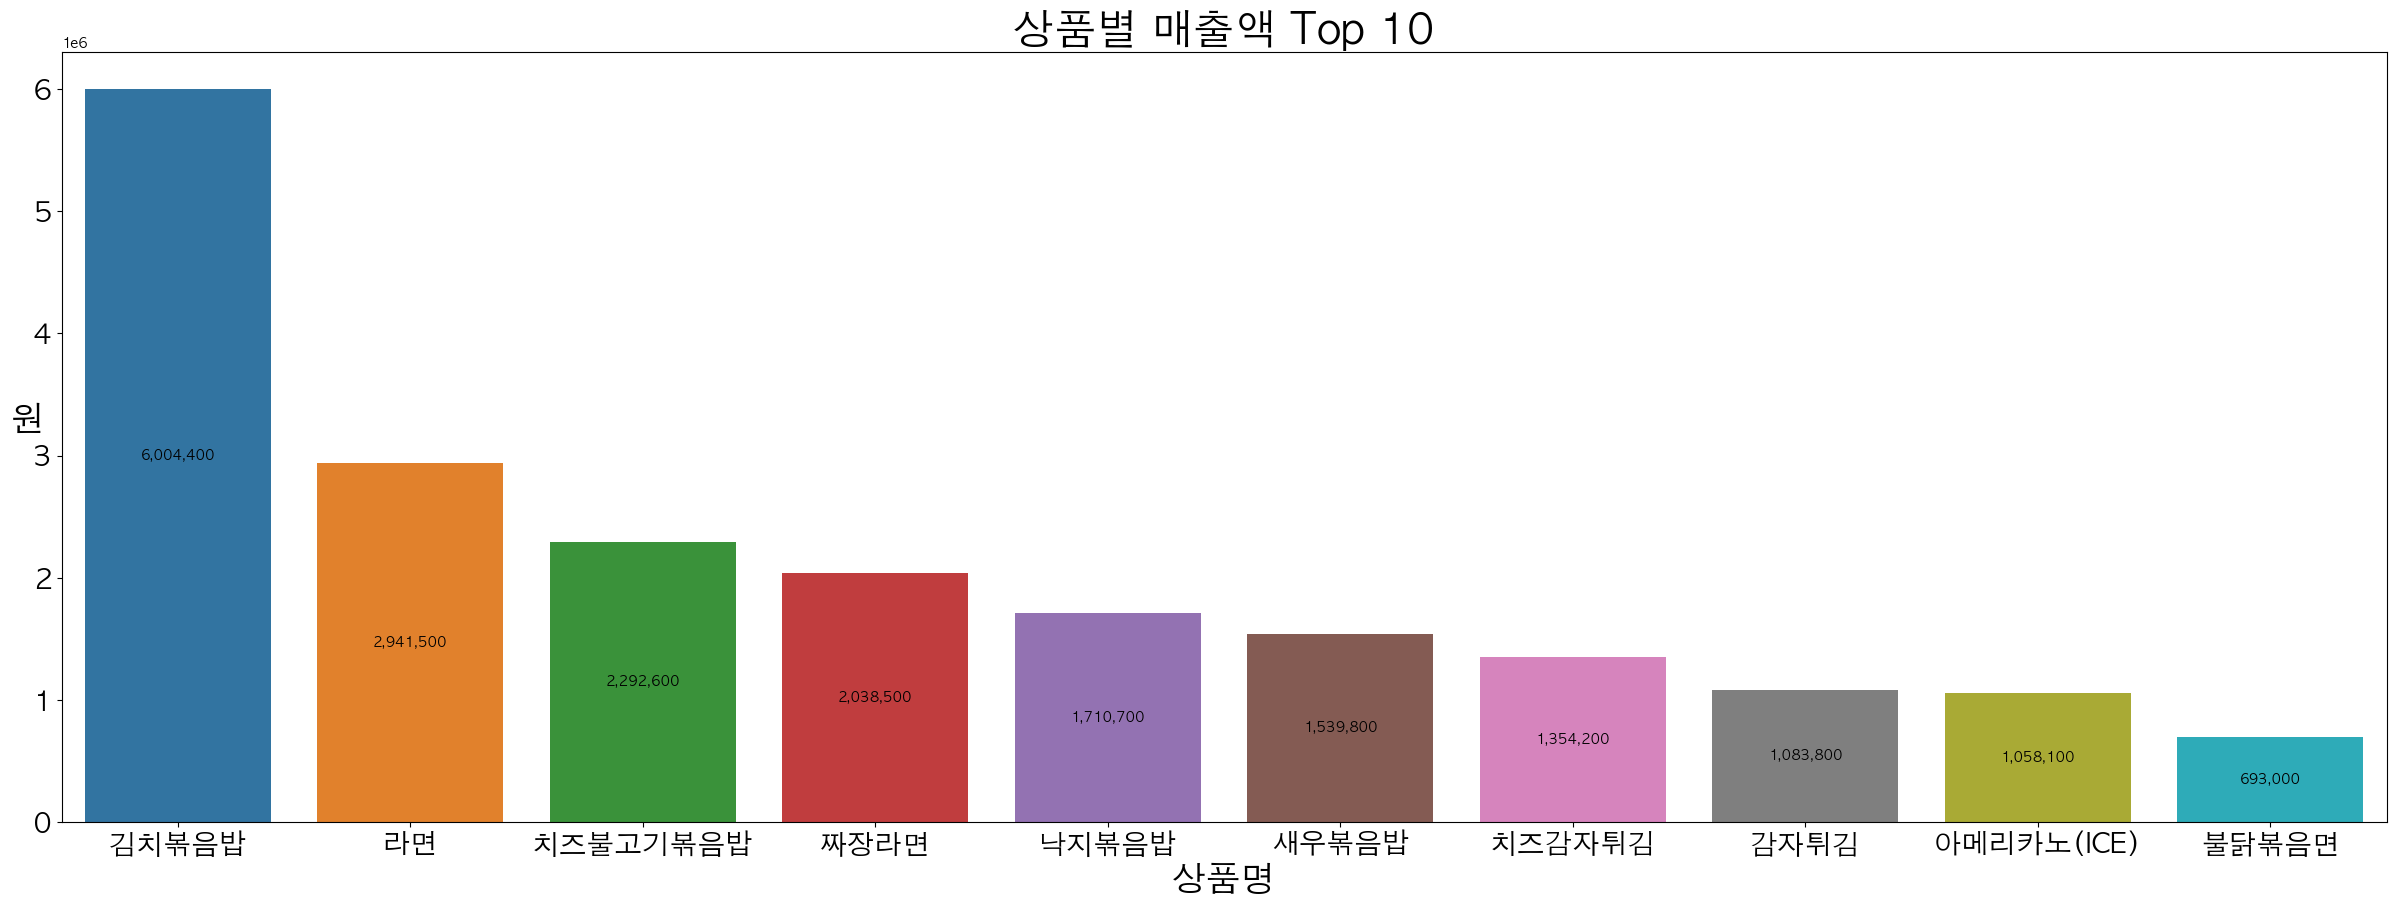

In [13]:
# 집계 결과 시각화
plt.figure(figsize = (30, 10))
ax = sns.barplot(data=items_payment_top10, x='상품명', y='매출액')
containers = ax.containers[0]
ax.bar_label(containers, labels=[f'{x:,.0f}' for x in containers.datavalues], label_type='center')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('상품명', fontsize = 25)
plt.ylabel('원', fontsize = 25, rotation=0)
plt.title('상품별 매출액 Top 10', fontsize = 30)
plt.show()

### - 3) 가장 많이 팔린 입장권 종류

In [14]:
# 활용할 데이터(entry_data)를 entry_df로 정의하기
entry_df = entry_data

del entry_df['위치']
del entry_df['구분']

# entry_df의 금액을 숫자형태로 변환하기
entry_df['금액'] = entry_df['금액'].astype(int)
entry_df.head(1)

,요금제명,입실,퇴실,이용,금액,고객
0,시간요금제(1시간),2022-04-01 23:39,2022-04-02 0:39,오전 1:00:00,3000,customer263717


In [15]:
# entry_df의 금액을 요금제명을 기준으로 집계하기
tickets = entry_df['금액'].groupby(entry_df['요금제명']).sum()

# tickets의 값을 내림차순으로 정렬하고 상위 10개 도출하기
tickets = tickets.sort_values(ascending=False)
tickets_top10 = tickets[:10]
tickets_top10 = pd.DataFrame(tickets_top10)
tickets_top10.reset_index(drop=False, inplace=True)
tickets_top10.rename(columns={'금액':'매출액'}, inplace=True)
tickets_top10

,요금제명,매출액
0,한국대생 입장권(종일권),70037000
1,입장권(종일권),23570500
2,심야-조조무제한(06시까지),11600000
3,심야-조조무제한,6221000
4,한국대생 무제한 입장권,5207500
5,시간요금제(1시간),2665500
6,시간요금제(3시간),2042000
7,무제한 입장권,1568600
8,18시이후 무제한,1330500
9,조조무제한,693000


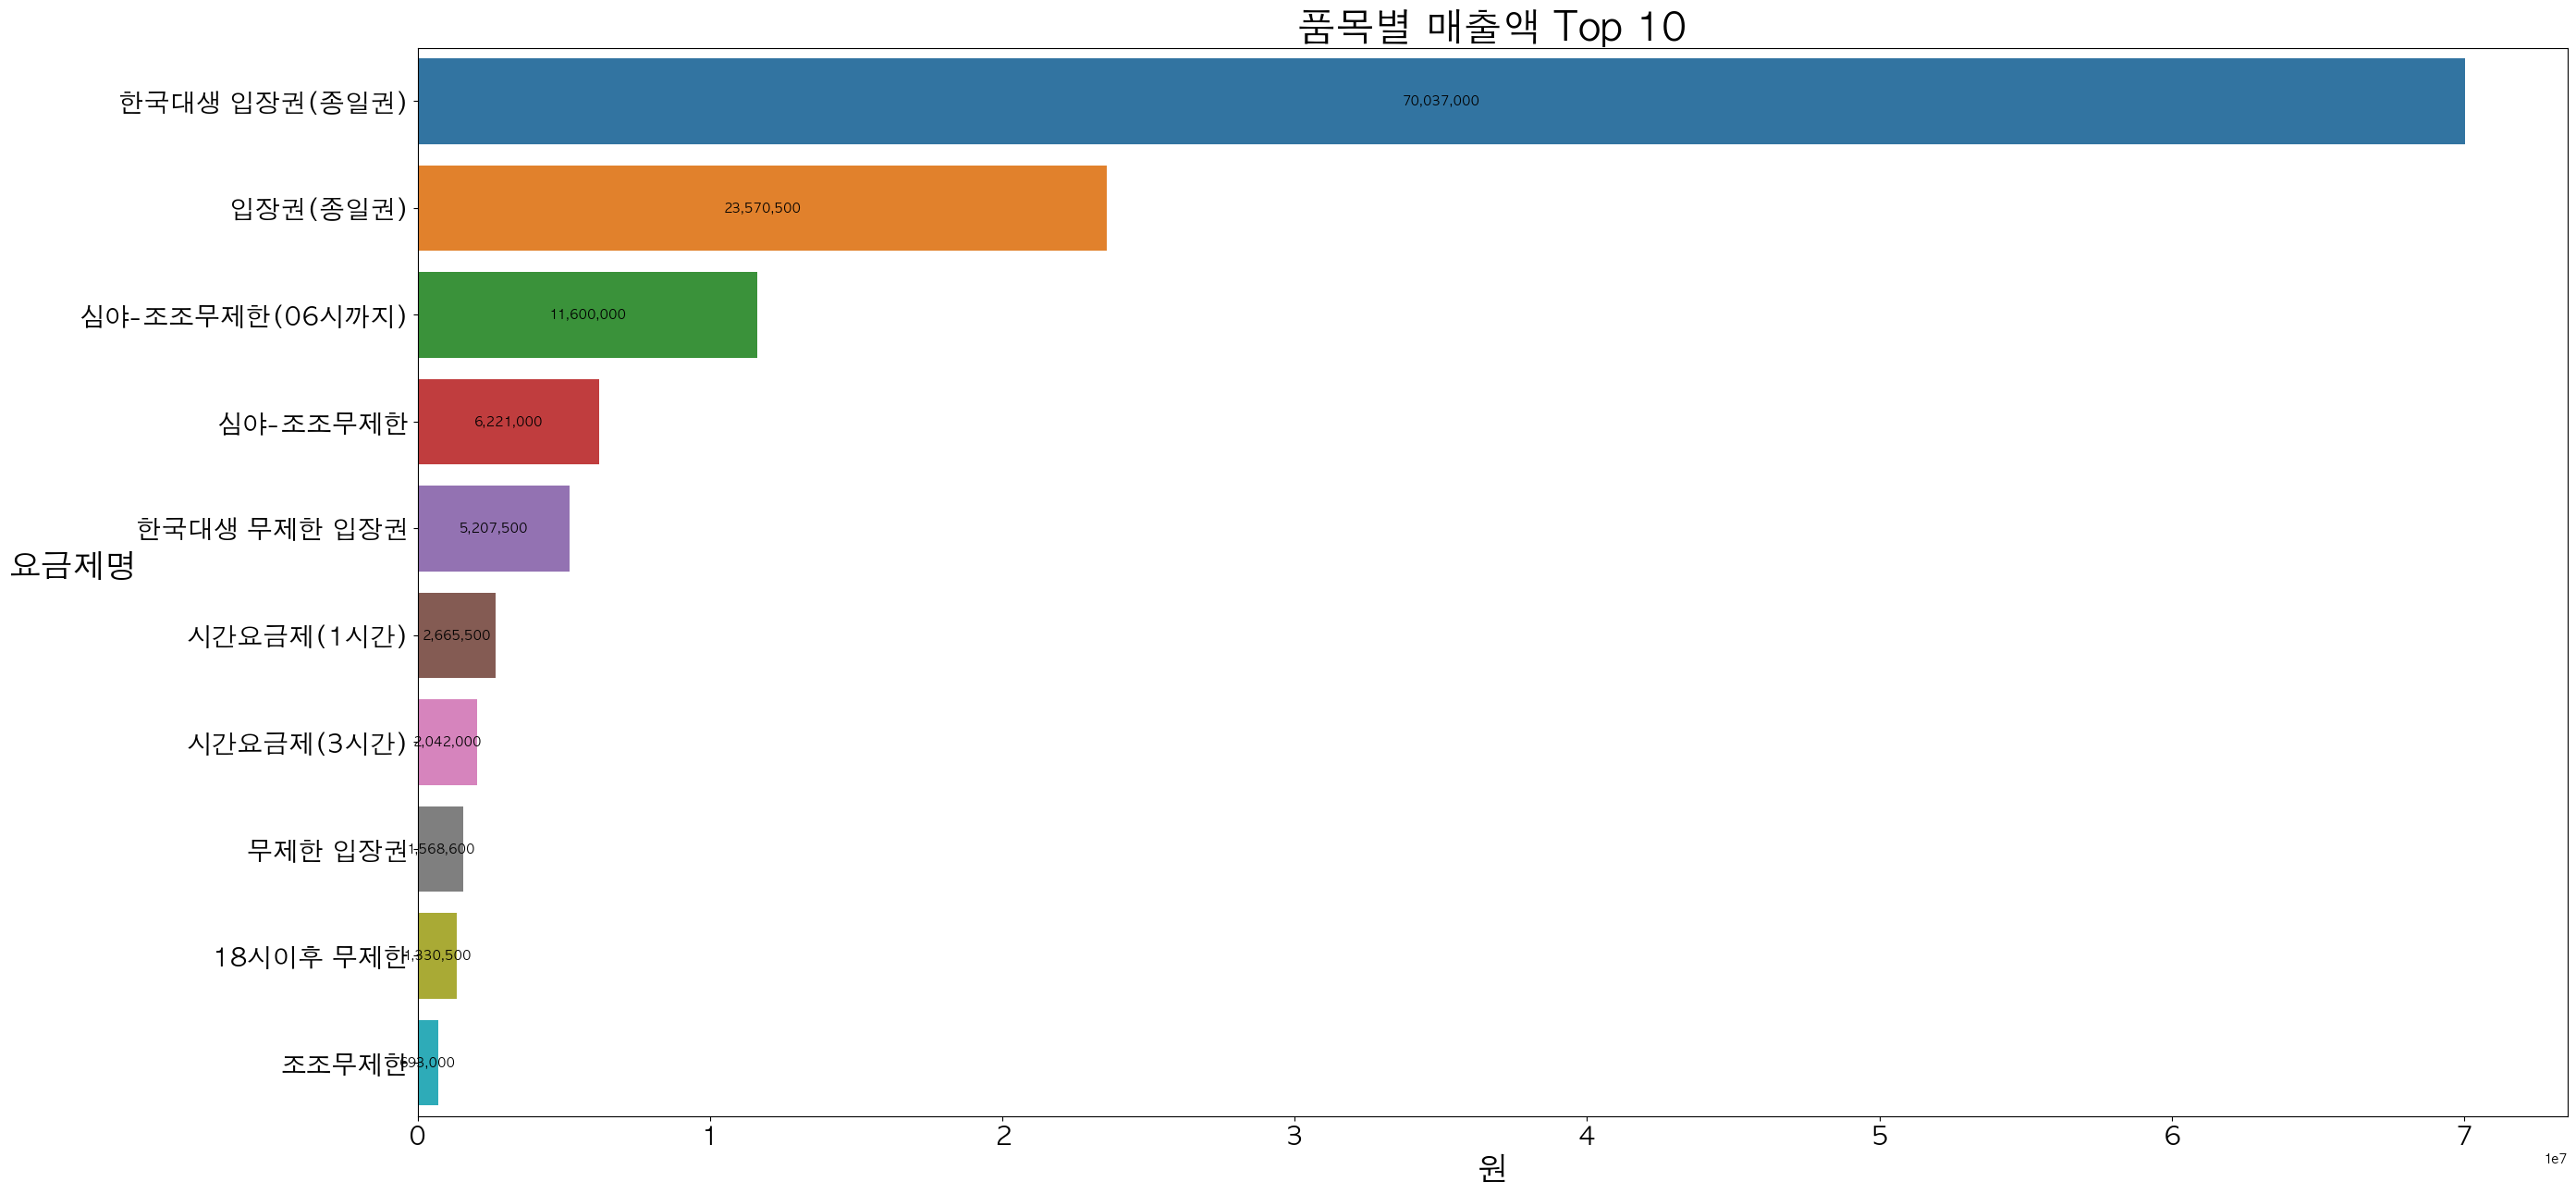

In [16]:
# 집계 결과 시각화
plt.figure(figsize = (30, 15))
ax = sns.barplot(data=tickets_top10, y='요금제명', x='매출액')
containers = ax.containers[0]
ax.bar_label(containers, labels=[f'{x:,.0f}' for x in containers.datavalues], label_type='center')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('원', fontsize = 25)
plt.ylabel('요금제명', fontsize = 25, rotation=0)
plt.title('품목별 매출액 Top 10', fontsize = 30)
plt.show()

# 3. 전략 수립 및 실행

'모두카페'에게 어떤 전략을 제안할 수 있나요?

## (1) 데이터 분석 결과 요약

1. 월별 매출액 추세 
 - 여름, 겨울에 매출이 급감, 2022년 4월 매출 급감
 

2. 가장 인기있는 음식/음료 
 - 1) 김치볶음밥 (5900원) 
 - 2) 라면 (4000원) 
 - 3) 치즈불고기볶음밥 (6400원)
 

3. 가장 많이 팔린 입장권 종류 
 - 1) 한국대생 입장권(종일권) (6000원) 
 - 2) 입장권(종일권) (7000원) 
 - 3) 심야-조조무제한(06시까지) (5000원)

In [17]:
# 가장 많이 팔린 음식 Top3 , 가장 많이 팔린 입장권 Top3의 가격

sales_df[sales_df['상품명'] == '김치볶음밥'].head(1)                # 5900원
sales_df[sales_df['상품명'] == '라면'].head(1)                    # 4000원
sales_df[sales_df['상품명'] == '치즈불고기볶음밥'].head(1)           # 6400원

entry_df[entry_df['요금제명'] == '한국대생 입장권(종일권)'].head(1)    # 6000원
entry_df[entry_df['요금제명'] == '입장권(종일권)'].head(1)           # 7000원
entry_df[entry_df['요금제명'] == '심야-조조무제한(06시까지)'].head(1)  # 5000원

,요금제명,입실,퇴실,이용,금액,고객
11779,심야-조조무제한(06시까지),2021-07-11 22:26,2021-07-11 23:45,오전 1:19:00,5000,customer846245


## (2) 문제점

### - 1) 여름, 겨울 매출 급감

 - 대학 앞에 있는 스터디 카페이다 보니 매출현황이 대학 학기 패턴을 따라가는 경향이 있어 '방학기간의 매출이 급감'

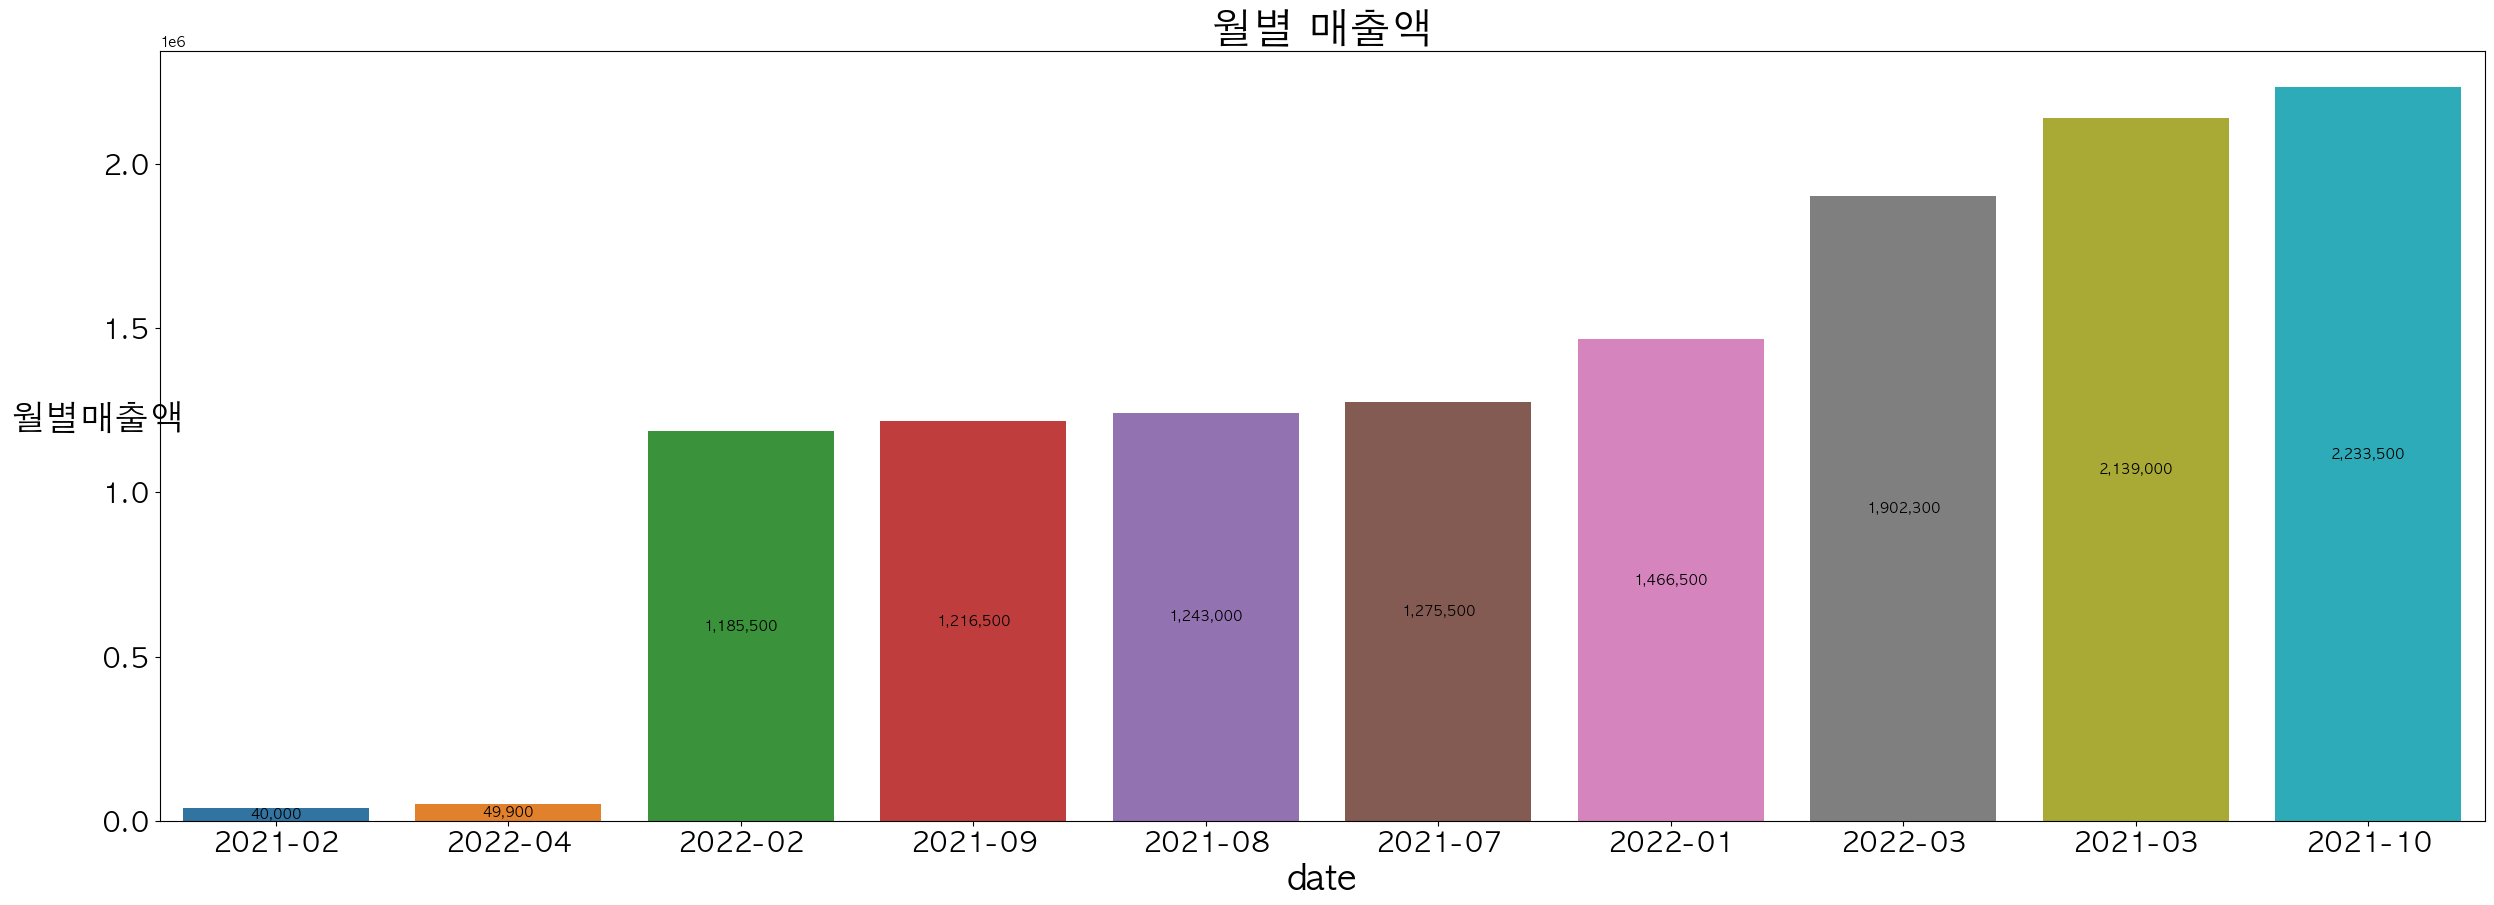

In [18]:
payment_data_new = payment_data.sort_values('월별매출액',ascending=True)
payment_data_new = payment_data_new[:10]

# 집계 결과 시각화
plt.figure(figsize = (30, 10))
ax = sns.barplot(data=payment_data_new, x='date', y='월별매출액')
containers = ax.containers[0]
ax.bar_label(containers, labels=[f'{x:,.0f}' for x in containers.datavalues], label_type='center')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('date', fontsize = 25)
plt.ylabel('월별매출액', fontsize = 25, rotation=0)
plt.title('월별 매출액', fontsize = 30)
plt.show()

2021년 2월부터 2022년 4월까지의 '모두 스터디 카페'의 월별 매출액 현황을 분석한 결과 2021년 2월 → 2022년 4월 → 여름(7월-9월) → 겨울(1월-2월) 순으로 매출이 적었다.

### - 2) 2022년 4월의 매출 급감

- 2022년 4월은 특별히 학생들의 방학기간도 아니고, 시험기간을 앞두고 있음에도 불구하고 매출이 급감하였다. 주변에 다른 신규 진입자 있을 확률이 가장 크므로, 빠른 원인 조사를 통한 대응이 필요하겠다.

## (3) 전략 수립 및 실행

### - 여름, 겨울 매출 급감의 해결 방안

- 대학 앞의 스터디 카페이다 보니 매출 현황이 대학 학기 패턴을 따라가고 있는 것으로 보인다. 품목별 매출액 Top 10에 비추어 볼 때, 한국대생 입장권(종일권)의 매출액의 비율이 큰 것으로 보아 한국대생의 방학기간의 이용 시간이 줄어드는 것이 매출 급감의 가장 큰 이유로 추정된다.

1. 한국대생의 방학기간 이용을 활성화 하기 위한 전략이 필요
  
  
     - 방학기간인 7월-8월, 1월-2월 : 2달 등록시 총 금액의 30% 할인
     
       6000원 * 60일 = 36만원  →  4000원 * 60일 = 24만 : 33% 할인
       
       → 방학기간의 매출감소가 크므로 할인율 상승을 통한 매출 증대가 시급
        
2. 가장 많이 인기있는 음식 top3의 가격을 방학기간 한정 20% 인하
        
      - 김치볶음밥 : 5900원 → 4700원
        
      - 라면 : 4000원 → 3200원
        
      - 치즈불고기볶음밥 : 6400 → 5100원
        
        → 가장 인기있는 음식의 가격을 할인하여, 학생들은 비용을 절감하고, 모두카페는 추가 수요로 인한 음식 매출 증대 가능
        
        
3. 모두카페 주위의 중, 고등학생의 방학 학정 특별 요금 적용
   
      - 종일권 7000원  (3500원 * 60일 = 21만원) -50% 할인

# 4. References

[1] https://lms.aiffel.io/course/383/node/660